In [183]:
import pandas as pd
import sklearn as sk
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import Normalizer
import networkx as nx
from scipy.linalg import norm
from scipy import sum, average
import cv2

from scipy.stats import zscore

from scipy.spatial.distance import cdist

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import png
from PIL import Image

In [184]:
path = "."

features = pd.read_csv(
    filepath_or_buffer='{path}/x_train_gr_smpl.csv'.format(path=path),
    sep=',', na_values='None', decimal='.')

classes = pd.read_csv(
    filepath_or_buffer='{path}/y_train_smpl.csv'.format(path=path),
    sep=',', na_values='None', decimal='.')

In [185]:
classes = classes.rename({'0': 'class'}, axis='columns')
roadsigns = pd.concat([features, classes], axis = 1)
roadsigns = sk.utils.shuffle(roadsigns)

def getInstancesFromClass(classAttribute, dataframe):
    a = dataframe.loc[dataframe['class'] == classAttribute]
    return a.drop(['class'], axis = 1)

def getLabelsFromClass(classAttribute, dataframe):
    a = dataframe.loc[dataframe['class'] == classAttribute]
    return a.loc[:, 'class']

def allInstancesToMatrix(instances):
    matrices = []
    if len(instances) == 1:
        matrices = (instances.iloc[[0]]).values.reshape(48,48)
    else:
        for i in range(len(instances)):
            matrices.append((instances.iloc[[i]]).values.reshape(48,48))
    return matrices

In [5]:
def getAccuracyScore(train_x, train_y, test_x, test_y):
    model = MultinomialNB()

    # Train the model 
    model.fit(train_x, train_y)

    # Predict Output 
    pred = model.predict(test_x)

    # returns the accuracy score
    return accuracy_score(test_y, pred)

In [6]:
def createBeans(nbBeans):
    beans = []
    for i in range(nbBeans - 1):
        beans.append(255 / nbBeans * (nbBeans - i - 1))
    return beans

def putValuesInBeans(beans, x):
    for i in beans:
        if x >= i:
            return 255 / (beans.index(i) + 1)
    return 0

In [ ]:
signs = getInstancesFromClass(0, roadsigns)
original_signs = allInstancesToMatrix(signs)

# separate colors in beans
beans = createBeans(4)
signs = signs.applymap(lambda x : putValuesInBeans(beans, x))
#converting the instances from row to matrix form so they can be plotted
signs = allInstancesToMatrix(signs)

# display street signs
i = 0
while i < len(signs):
    plt.imshow(signs[i], cmap=cm.Greys)
    plt.show(block=True)
    plt.imshow(original_signs[i], cmap=cm.Greys)
    plt.show(block=True)
    i += 1

In [7]:
# create matrix of same size than roadsigns with 80% of true and 20% of false
msk = np.random.rand(len(roadsigns)) < 0.8

# separate dataframe into a training and testing sets
train_x = roadsigns[msk]
test_x = roadsigns[~msk]

# remove last columns for x sets and the rest for y sets
train_y = train_x.loc[:, 'class']
train_x = train_x.drop(['class'], axis=1)
test_y = test_x.loc[:, 'class']
test_x = test_x.drop(['class'], axis=1)

0.4729102167182663


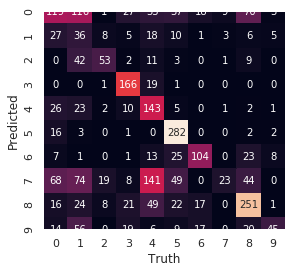

In [8]:
# uses Mutlinomial naive bayes on the whole data
model = MultinomialNB()

# Train the model 
model.fit(train_x, train_y)

# Predict Output 
pred = model.predict(test_x)

# Plot Confusion Matrix
mat = confusion_matrix(pred, test_y)
names = np.unique(pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
print(accuracy_score(test_y, pred))

In [263]:
def naive_bayes(x, train_x, train_y, test_x, test_y):
    # uses Gaussian naive bayes on the whole data
    model = GaussianNB()
    
    # if function is called with parameter x - 
    # then pixel intensity values are split into x number of bins
    if x is not None:
        bins = createBins(x)
        train_x = train_x.applymap(lambda x : putValuesInBins(bins, x))
        test_x = test_x.applymap(lambda x : putValuesInBins(bins, x))

    # Train the model 
    model.fit(train_x, train_y)

    # Predict Output 
    pred = model.predict(test_x)

    # Plot Confusion Matrix
    mat = confusion_matrix(test_y, pred)
    # Normalising the matrix 
    cm = mat/ mat.sum(axis=1)[:, np.newaxis]
    names = np.unique(pred)
    ax = sns.heatmap(mat, square=True, annot=True, cbar=False,
                xticklabels=names, yticklabels=names, fmt="d" )
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show(block=True)
    print(accuracy_score(test_y,pred))  
    return mat

def precision_recall(mat):
    f, (prec, rec) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

    precision = []
    for i in range(10):
        precision.append((mat[i,i])/ (sum(mat[:, i])))

    recall = []
    for i in range(10):
        recall.append((mat[i,i])/ (sum(mat[i, :])))

    x = np.array([0,1,2,3,4,5,6,7,8,9])

    precision  = np.array(precision)
    recall  = np.array(recall)

    sns.barplot(x = x, y = precision, palette="deep", ax=prec)
    prec.set_xlabel("Precision per class")

    sns.barplot(x = x, y = recall, palette="deep", ax=rec)
    rec.set_xlabel("Recall per class")
    
def create_train_test_sets(df):
    # create matrix of same size than roadsigns with 80% of true and 20% of false
    msk = np.random.rand(len(df)) < 0.8

    # separate dataframe into a training and testing sets
    train_x = df[msk]
    test_x = df[~msk]

    # remove last columns for x sets and the rest for y sets
    train_y = train_x.loc[:, 'class']
    train_x = train_x.drop(['class'], axis=1)
    test_y = test_x.loc[:, 'class']
    test_x = test_x.drop(['class'], axis=1)
    
    train_test = {
        "train_x": train_x,
        "train_y": train_y,
        "test_x": test_x,
        "test_y": test_y
    }
    return train_test


Train 0.29773719730051607


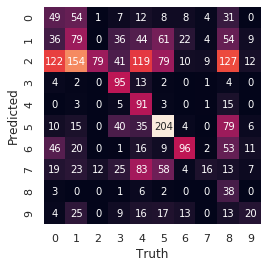

Test 0.2968266253869969


In [10]:
# basic naive bayes on data without preprocessing
naive_bayes(None, train_x, train_y, test_x, test_y)

In [ ]:
# basic naive bayes on data with beaning according to pixel value
for i in range(2, 10):
    naive_bayes(i, train_x, train_y, test_x, test_y)

Train 0.29773719730051607


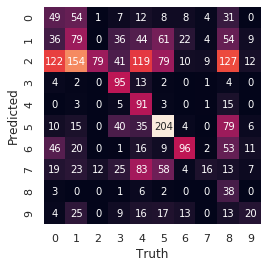

Test 0.2968266253869969


In [11]:
# naive bayes on data with basic normalization (values between 0 and 1)
norm_train_x = train_x.applymap(lambda x: x / 255)
norm_test_x = test_x.applymap(lambda x: x / 255)
naive_bayes(None, norm_train_x, train_y, norm_test_x, test_y)

Train 0.556173084557364


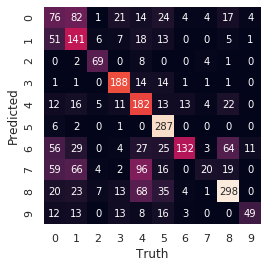

Test 0.5580495356037152


In [12]:
# l2-norm

values = train_x.values
values_test = test_x.values

transformer = Normalizer().fit(values)
values_x = transformer.transform(values)
transformer = Normalizer().fit(values_test)
values_test_x = transformer.transform(values_test)

norm_test_x = pd.DataFrame(data=values_test_x)
norm_train_x = pd.DataFrame(data=values_x)
naive_bayes(None, norm_train_x, train_y, norm_test_x, test_y)

In [ ]:
signs = getInstancesFromClass(9, roadsigns)
#signs0 = np.array(allInstancesToMatrix(roadsigns.drop(['class'], axis = 1)
#))
signs0 = np.array(allInstancesToMatrix(signs))
a = signs0.mean(axis=0)
png.from_array(a.astype(int).tolist(), 'L').save("./small_smiley.png")

In [13]:
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng
def compare_images(img1, img2):
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference
    diff = img1 - img2
    norm = sum(abs(diff))
    return norm

In [14]:
def remove_bad_instances(class_attribute, max_score, dataframe):
    signs = getInstancesFromClass(class_attribute, dataframe)
    labels = getLabelsFromClass(class_attribute, dataframe)
    signs0 = np.array(allInstancesToMatrix(signs))
    a = signs0.mean(axis=0)
    #plt.imshow(a, cmap=cm.Greys)
    #plt.show(block=True)
    y = 0
    scores = []
    for i in signs0:
        scores.append(compare_images(a, i))
    new_scores = list(filter(lambda x : x < max_score, scores))
    indexes = []
    index = 0
    #print(len(scores))
    for score in scores:
        if score >= max_score:
            indexes.append(index)
        index += 1
    #print(len(new_scores))
    #print(len(indexes))
    dataframe_indexes = []
    for index in sorted(indexes):
        dataframe_indexes.append(signs.index[index])
    new_signs = signs.drop(dataframe_indexes)
    new_labels = labels.drop(dataframe_indexes)
    new_signs = pd.concat([new_signs, new_labels], axis = 1)
    return new_signs

In [18]:
# create matrix of same size than roadsigns with 80% of true and 20% of false
msk = np.random.rand(len(roadsigns)) < 0.8

# separate dataframe into a training and testing sets
train_set = roadsigns[msk]
test_set = roadsigns[~msk]

In [ ]:
separated[9]

In [ ]:
for i in range(2, 10):
    naive_bayes(i, train_x, train_y, test_x, test_y)

In [ ]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [ ]:
# create matrix of same size than roadsigns with 80% of true and 20% of false
msk = np.random.rand(len(roadsigns)) < 0.8

# separate dataframe into a training and testing sets
train_set = roadsigns[msk]
test_set = roadsigns[~msk]
# remove last columns for x sets and the rest for y sets
train_y = train_set.loc[:, 'class']
train_x = train_set.drop(['class'], axis=1)
test_y = test_set.loc[:, 'class']
test_x = test_set.drop(['class'], axis=1)

In [ ]:
# create matrix of same size than roadsigns with 80% of true and 20% of false
msk = np.random.rand(len(roadsigns)) < 0.8

# separate dataframe into a training and testing sets
train_set = roadsigns[msk]
test_set = roadsigns[~msk]

final_test_x = []
final_test_y = []
final_train_x = []
final_train_y = []
for i in range(10):
    x = getInstancesFromClass(i, train_set)
    final_train_y.extend([i] * len(x))
    x = np.array(allInstancesToMatrix(x))
    final_train_x.append(x)
    x_test = getInstancesFromClass(i, test_set)
    final_test_y.extend([i] * len(x_test))
    x_test = np.array(allInstancesToMatrix(x_test))
    final_test_x.append(x_test)
    
final_test_x = np.concatenate(tuple(final_test_x), axis=0)
final_train_x = np.concatenate(tuple(final_train_x), axis=0)
final_test_y = np.array(final_test_y).T
final_train_y = np.array(final_train_y).T

In [ ]:
print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

In [ ]:
print('Training data shape : ', final_train_x.shape, final_train_y.shape)

print('Testing data shape : ', final_test_x.shape, final_test_y.shape)

In [ ]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

In [ ]:
classes = np.unique(final_train_y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(final_train_x[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(final_train_y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(final_test_x[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(final_test_y[0]))

In [ ]:
final_train_x = final_train_x.reshape(-1, 48,48, 1)
final_test_x = final_test_x.reshape(-1, 48,48, 1)
final_train_x.shape, final_test_x.shape

In [ ]:
final_train_x = final_train_x.astype('float32')
final_test_x = final_test_x.astype('float32')
final_train_x = final_train_x / 255.
final_test_x = final_test_x / 255.

In [ ]:
# Change the labels from categorical to one-hot encoding
final_train_y_one_hot = to_categorical(final_train_y)
final_test_y_one_hot = to_categorical(final_test_y)

# Display the change for category label using one-hot encoding
print('Original label:', final_train_y[0])
print('After conversion to one-hot:', final_train_y_one_hot[0])

In [ ]:
final_train_y_one_hot

In [ ]:
final_train_x.shape,final_test_x.shape,final_train_y_one_hot.shape,final_test_y_one_hot.shape

In [ ]:
batch_size = 64
epochs = 20
num_classes = 10

In [ ]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(48,48,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
fashion_model.summary()

In [ ]:
fashion_train = fashion_model.fit(final_train_x, final_train_y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(final_test_x, final_test_y_one_hot))

In [255]:
dataframes = []
for i in range(10):
    pic = Image.open("signs" + str(i) + ".png")
    pix = np.array(pic)
    pix.shape
    mask0 = pd.DataFrame(pix).applymap(lambda x: 1 if x == 255 else 0)
    signs0 = getInstancesFromClass(i, roadsigns)
    mask0 = mask0.values.reshape(1, 2304)
    mask0 = pd.DataFrame(mask0)
    temp_mask0 = mask0
    for x in range(len(signs0) - 1):
        mask0 = pd.concat([mask0, temp_mask0], ignore_index=True)
    ok_dataframe = pd.DataFrame(mask0.values*signs0.values)
    dataset = pd.DataFrame({'class': np.full((len(signs0), 1), i)[:, 0]})
    ok_dataframe = pd.concat([ok_dataframe, dataset], axis = 1)
    dataframes.append(ok_dataframe)

In [257]:
full_signs = pd.concat(dataframes, ignore_index=True)

In [258]:
full_signs = sk.utils.shuffle(full_signs)

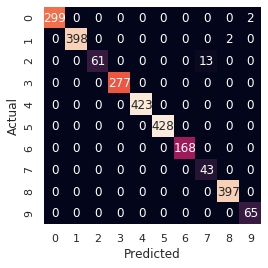

0.9934006211180124


In [260]:
# create matrix of same size than roadsigns with 80% of true and 20% of false
msk = np.random.rand(len(full_signs)) < 0.8

# separate dataframe into a training and testing sets
train_x = full_signs[msk]
test_x = full_signs[~msk]

# remove last columns for x sets and the rest for y sets
train_y = train_x.loc[:, 'class']
train_x = train_x.drop(['class'], axis=1)
test_y = test_x.loc[:, 'class']
test_x = test_x.drop(['class'], axis=1)
# basic naive bayes on data without preprocessing
mat = naive_bayes(None, train_x, train_y, test_x, test_y)

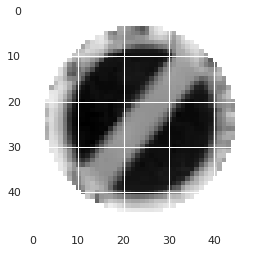

In [265]:
plt.imshow(allInstancesToMatrix(getInstancesFromClass(7, full_signs))[0], cm.Greys)
plt.show()

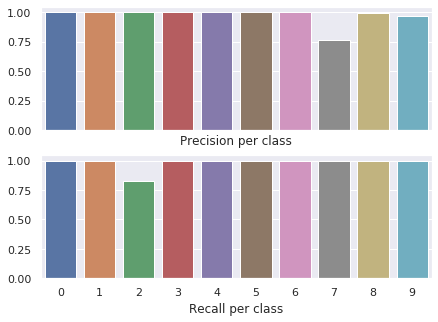

In [266]:
precision_recall(mat)

In [33]:
##################################
#         CLUSTERING             #
##################################

In [60]:
def kmeans_clustering(dataframe, nb_clusters, unsupervised=False):
    if unsupervised:
        X = dataframe.drop(['class'], axis=1).values
    else:
        X = dataframe.values
    Y = dataframe.loc[:, 'class'].values
    
    transformer = Normalizer().fit(X)
    X = transformer.transform(X)
    
    k_means = KMeans(n_clusters=nb_clusters, max_iter=1000)
    k_means.fit(X)
    print(accuracy_score(Y, k_means.predict(X)))

    mat = confusion_matrix(Y, k_means.predict(X))
    names = np.unique(k_means.predict(X))
    ax = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                     xticklabels=names, yticklabels=names)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    plt.show(block=True)

def meanshift_clustering(dataframe, nb_clusters, unsupervised=False):
    if unsupervised:
        X = dataframe.drop(['class'], axis=1).values
    else:
        X = dataframe.values
    Y = dataframe.loc[:, 'class'].values
    
    transformer = Normalizer().fit(X)
    X = transformer.transform(X)
    
    clustering = MeanShift(bandwidth=nb_clusters)
    clustering = clustering.fit(X)
    print(accuracy_score(Y, clustering.predict(X)))

    mat = confusion_matrix(Y, clustering.predict(X))
    names = np.unique(clustering.predict(X))
    ax = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                     xticklabels=names, yticklabels=names)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    plt.show(block=True)
    
def agglomerative_clustering(dataframe, nb_clusters, unsupervised=False):
    if unsupervised:
        X = dataframe.drop(['class'], axis=1).values
    else:
        X = dataframe.values
    Y = dataframe.loc[:, 'class'].values
    
    transformer = Normalizer().fit(X)
    X = transformer.transform(X)
    
    clustering = AgglomerativeClustering(n_clusters=nb_clusters)
    clustering = clustering.fit(X)
    predictions = clustering.fit_predict(X)
    print(accuracy_score(Y, predictions))

    mat = confusion_matrix(Y, predictions)
    names = np.unique(predictions)
    ax = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                     xticklabels=names, yticklabels=names)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    plt.show(block=True)

0.07835703001579779


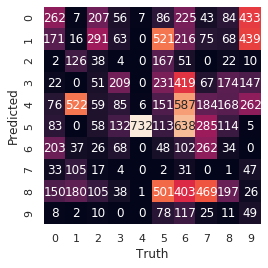

In [64]:
kmeans_clustering(roadsigns, 10, True)

In [30]:
separated = []
for i in range(10):
    temp_roadsigns2 = roadsigns
    temp_roadsigns2_y = temp_roadsigns2.loc[:, 'class']
    temp_roadsigns2_x = temp_roadsigns2.drop(['class'], axis=1)
    temp_roadsigns2_y = temp_roadsigns2_y.apply(lambda x: 1 if x == i else 0)
    temp_roadsigns2 = pd.concat([temp_roadsigns2_x, temp_roadsigns2_y], axis = 1)
    separated.append(temp_roadsigns2)

0.4613744075829384


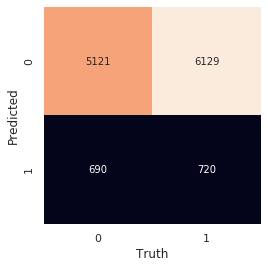

0.49123222748815165


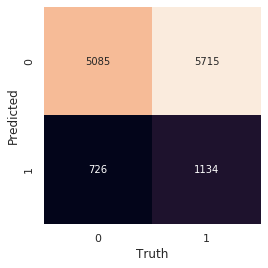

0.4774091627172196


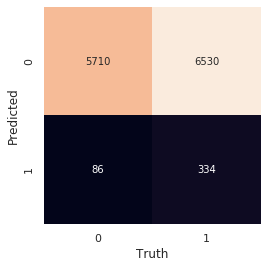

0.5509478672985783


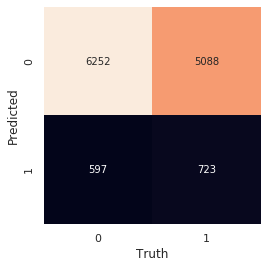

0.5068720379146919


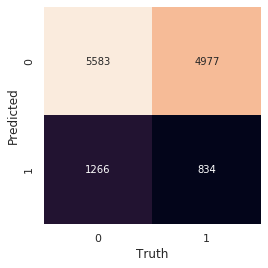

0.5075039494470774


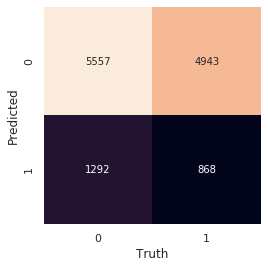

0.5809636650868878


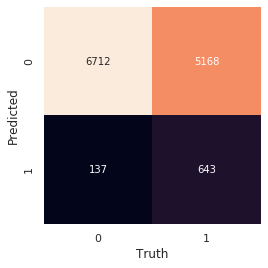

0.4665876777251185


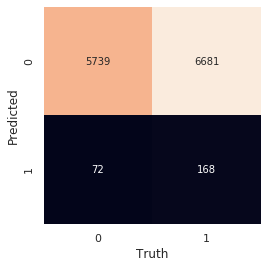

0.45268562401263823


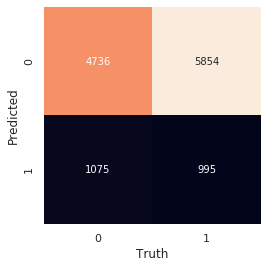

0.466824644549763


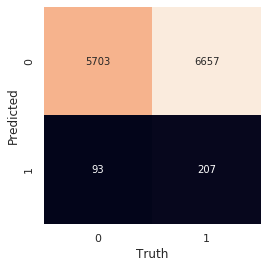

In [36]:
for i in range(10):
    kmeans_clustering(separated[i], 2, True)

0.4613744075829384


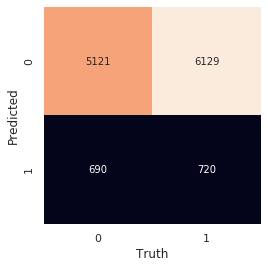

0.4903633491311216


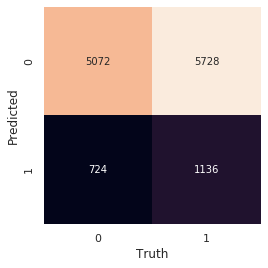

0.5214060031595577


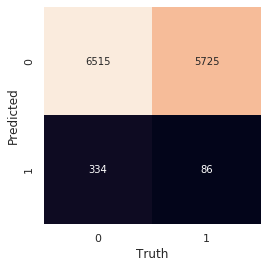

0.5509478672985783


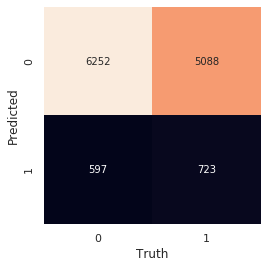

0.5068720379146919


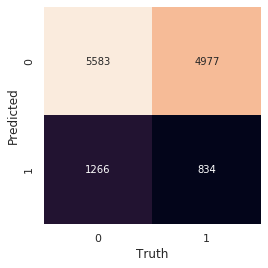

0.4924960505529226


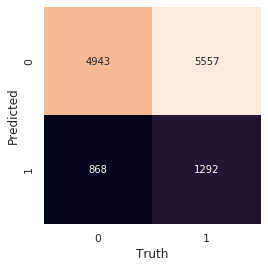

0.41903633491311215


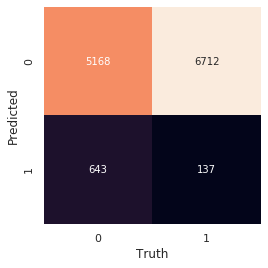

0.4665876777251185


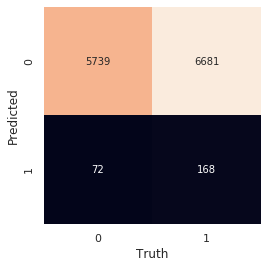

0.45268562401263823


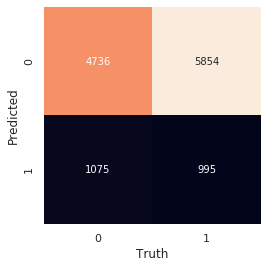

0.4678515007898894


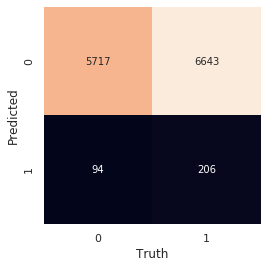

In [37]:
for i in range(10):
    kmeans_clustering(separated[i], 2, False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


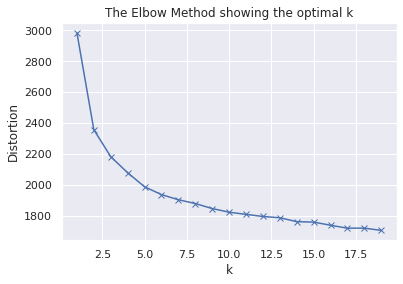

In [40]:
distortions = []
X = roadsigns
K = range(1, 20)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

1
2
3
4
5
6
7
8
9


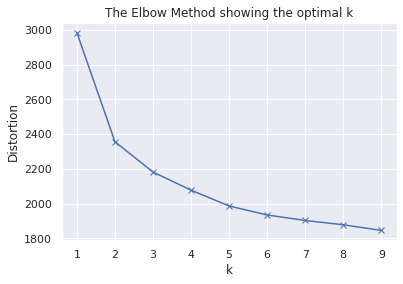

In [41]:
distortions = []
X = roadsigns
K = range(1, 10)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

0.037914691943127965


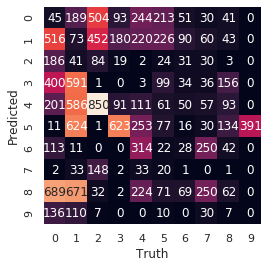

In [61]:
agglomerative_clustering(roadsigns, 10, True)

0
0.5335703001579779


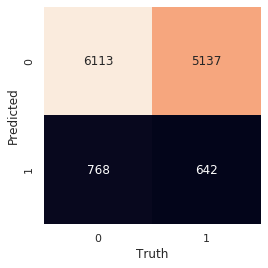

1
0.5779620853080568


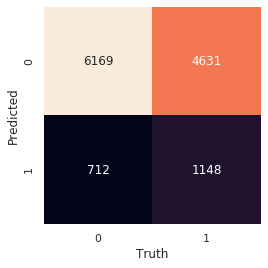

2
0.5560031595576619


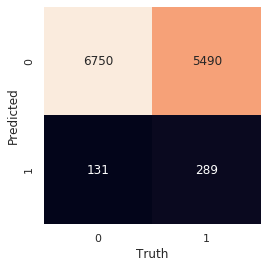

3
0.50260663507109


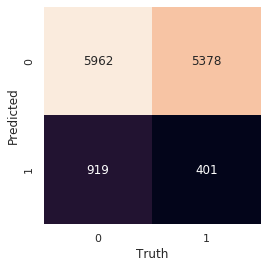

4
0.5580568720379147


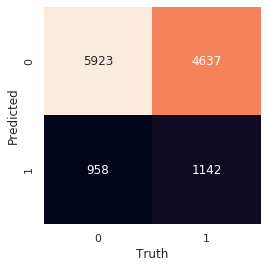

5
0.5349921011058452


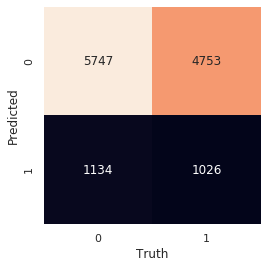

6
0.4997630331753555


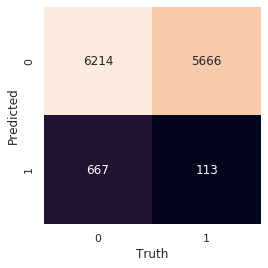

7
0.5485781990521327


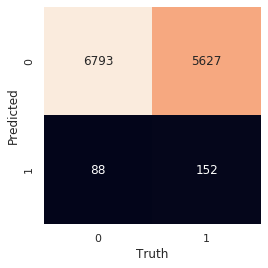

8
0.4942338072669826


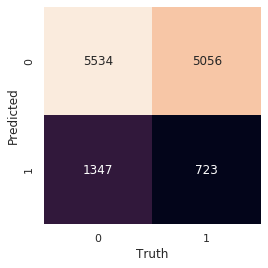

9
0.5424170616113744


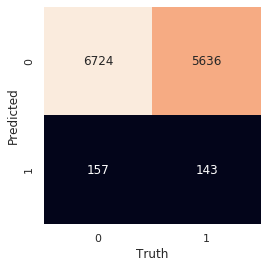

In [62]:
for i in range(10):
    print(i)
    agglomerative_clustering(separated[i], 2, False)

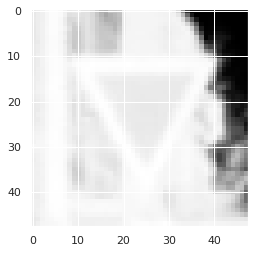

In [65]:
plt.imshow(allInstancesToMatrix(getInstancesFromClass(5, roadsigns))[0], cm.Greys)
plt.show()

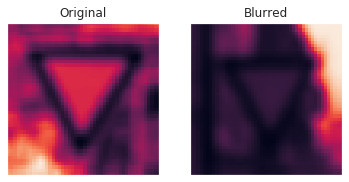

In [304]:
img = np.array(allInstancesToMatrix(getInstancesFromClass(5, roadsigns))[200]).astype('uint8')
img = cv2.blur(img,(5,5))
edges = cv2.Canny(img,50,50)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

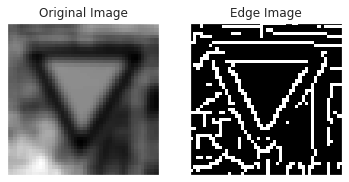

In [305]:
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [198]:
def edges_detection(x, y):
    dataframe_edges = []
    for i in range(len(roadsigns.drop(['class'], axis=1))):
        img = features.loc[i,:].values.reshape(48,48).astype('uint8')
        img = cv2.blur(img,(5,5))
        edges = cv2.Canny(img,x,y)
        dataframe_edges.append(pd.DataFrame(edges.reshape(1,2304)))
    dataframe_edges = pd.concat(dataframe_edges, ignore_index=True)
    dataframe_edges = pd.concat([dataframe_edges, classes], axis = 1)
    dataframe_edges = sk.utils.shuffle(dataframe_edges)
    sets = create_train_test_sets(dataframe_edges)
    naive_bayes(None, sets["train_x"], sets["train_y"], sets["test_x"], sets["test_y"])
    return dataframe_edges

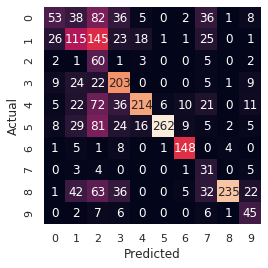

0.5429252782193958


In [300]:
dataframe_edges = edges_detection(50, 50)

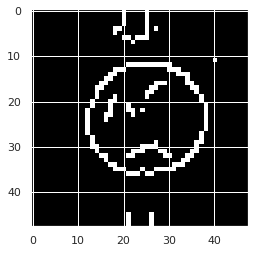

In [301]:
signs = getInstancesFromClass(0, dataframe_edges)
signs0 = np.array(allInstancesToMatrix(signs))
a = signs0.mean(axis=0)
plt.imshow(signs0[0],cmap = 'gray')

plt.show()